# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorboard.plugins.hparams import api as hp

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Trayectorias 100 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')

In [6]:
np.shape(varftrain)

(7000, 10, 2, 100)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')

In [10]:
np.shape(varftest)

(2000, 10, 2, 100)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')

In [14]:
np.shape(varfval)

(1000, 10, 2, 100)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(10, 2, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,2,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7)
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2000)              0         
                                                                 
 batch_normalization (BatchN  (None, 2000)             8000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               200100    
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 50)                1300      
                                                        

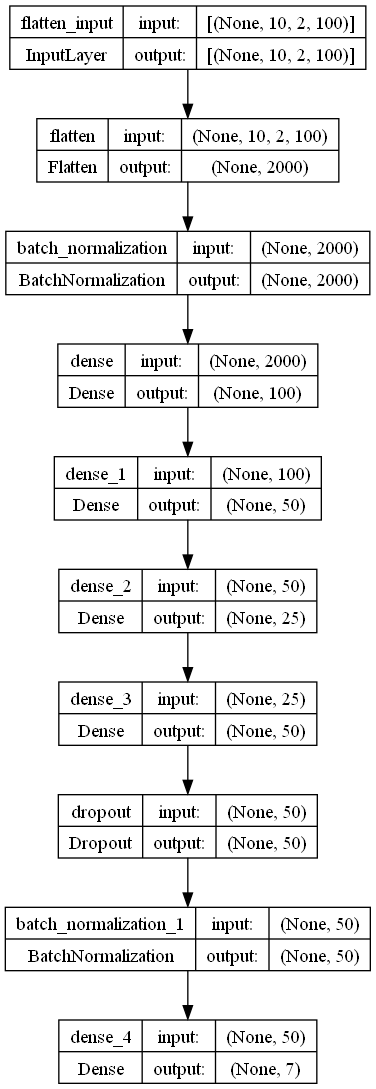

In [23]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [24]:
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])

In [25]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [26]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, 
                    callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 1s 4ms/step - loss: 4.5424 - mae: 4.5424 - val_loss: 4.5777 - val_mae: 4.5777 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.8923 - mae: 3.8923 - val_loss: 3.3049 - val_mae: 3.3049 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8840 - mae: 2.8840 - val_loss: 2.3831 - val_mae: 2.3831 - lr: 0.0010
Epoch 4/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.2981 - mae: 2.2981 - val_loss: 2.0920 - val_mae: 2.0920 - lr: 0.0010
Epoch 5/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.1113 - mae: 2.1113 - val_loss: 2.0103 - val_mae: 2.0103 - lr: 0.0010
Epoch 6/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.0437 - mae: 2.0437 - val_loss: 1.8595 - val_mae: 1.8595 - lr: 0.0010
Epoch 7/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.9846 - mae: 1.9846 - val_loss: 1.8942 - val_mae: 1.894

70/70 [==============================] - 0s 3ms/step - loss: 1.6112 - mae: 1.6112 - val_loss: 1.4725 - val_mae: 1.4725 - lr: 0.0010
Epoch 58/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6094 - mae: 1.6094 - val_loss: 1.4730 - val_mae: 1.4730 - lr: 0.0010
Epoch 59/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6111 - mae: 1.6111 - val_loss: 1.4520 - val_mae: 1.4520 - lr: 0.0010
Epoch 60/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5996 - mae: 1.5996 - val_loss: 1.4826 - val_mae: 1.4826 - lr: 0.0010
Epoch 61/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6076 - mae: 1.6076 - val_loss: 1.4782 - val_mae: 1.4782 - lr: 0.0010
Epoch 62/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6038 - mae: 1.6038 - val_loss: 1.4403 - val_mae: 1.4403 - lr: 0.0010
Epoch 63/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6005 - mae: 1.6005 - val_loss: 1.4837 - val_mae: 1.4837 - lr:

70/70 [==============================] - 0s 3ms/step - loss: 1.5479 - mae: 1.5479 - val_loss: 1.4563 - val_mae: 1.4563 - lr: 0.0010
Epoch 114/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5463 - mae: 1.5463 - val_loss: 1.4648 - val_mae: 1.4648 - lr: 0.0010
Epoch 115/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5490 - mae: 1.5490 - val_loss: 1.4312 - val_mae: 1.4312 - lr: 0.0010
Epoch 116/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5486 - mae: 1.5486 - val_loss: 1.4334 - val_mae: 1.4334 - lr: 0.0010
Epoch 117/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5456 - mae: 1.5456 - val_loss: 1.4366 - val_mae: 1.4366 - lr: 0.0010
Epoch 118/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5479 - mae: 1.5479 - val_loss: 1.4421 - val_mae: 1.4421 - lr: 0.0010
Epoch 119/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5416 - mae: 1.5416 - val_loss: 1.4513 - val_mae: 1.4513

Epoch 169/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5086 - mae: 1.5086 - val_loss: 1.4177 - val_mae: 1.4177 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4961 - mae: 1.4961 - val_loss: 1.4303 - val_mae: 1.4303 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5106 - mae: 1.5106 - val_loss: 1.4315 - val_mae: 1.4315 - lr: 0.0010
Epoch 172/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5116 - mae: 1.5116 - val_loss: 1.4248 - val_mae: 1.4248 - lr: 0.0010
Epoch 173/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4962 - mae: 1.4962 - val_loss: 1.4368 - val_mae: 1.4368 - lr: 0.0010
Epoch 174/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5014 - mae: 1.5014 - val_loss: 1.4477 - val_mae: 1.4477 - lr: 0.0010
Epoch 175/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5026 - mae: 1.5026 - val_loss: 1.4354 - 

Epoch 225/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4717 - mae: 1.4717 - val_loss: 1.4459 - val_mae: 1.4459 - lr: 0.0010
Epoch 226/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4771 - mae: 1.4771 - val_loss: 1.4280 - val_mae: 1.4280 - lr: 0.0010
Epoch 227/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4691 - mae: 1.4691 - val_loss: 1.4423 - val_mae: 1.4423 - lr: 0.0010
Epoch 228/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4722 - mae: 1.4722 - val_loss: 1.4205 - val_mae: 1.4205 - lr: 0.0010
Epoch 229/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4691 - mae: 1.4691 - val_loss: 1.4279 - val_mae: 1.4279 - lr: 0.0010
Epoch 230/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4723 - mae: 1.4723 - val_loss: 1.4281 - val_mae: 1.4281 - lr: 0.0010
Epoch 231/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4696 - mae: 1.4696 - val_loss: 1.4377 - 

Epoch 281/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4549 - mae: 1.4549 - val_loss: 1.4411 - val_mae: 1.4411 - lr: 0.0010
Epoch 282/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4560 - mae: 1.4560 - val_loss: 1.4166 - val_mae: 1.4166 - lr: 0.0010
Epoch 283/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4505 - mae: 1.4505 - val_loss: 1.4217 - val_mae: 1.4217 - lr: 0.0010
Epoch 284/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4550 - mae: 1.4550 - val_loss: 1.4190 - val_mae: 1.4190 - lr: 0.0010
Epoch 285/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4477 - mae: 1.4477 - val_loss: 1.4298 - val_mae: 1.4298 - lr: 0.0010
Epoch 286/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4457 - mae: 1.4457 - val_loss: 1.4400 - val_mae: 1.4400 - lr: 0.0010
Epoch 287/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4527 - mae: 1.4527 - val_loss: 1.4213 - 

Epoch 337/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4316 - mae: 1.4316 - val_loss: 1.4189 - val_mae: 1.4189 - lr: 0.0010
Epoch 338/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4330 - mae: 1.4330 - val_loss: 1.4367 - val_mae: 1.4367 - lr: 0.0010
Epoch 339/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4340 - mae: 1.4340 - val_loss: 1.4370 - val_mae: 1.4370 - lr: 0.0010
Epoch 340/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4323 - mae: 1.4323 - val_loss: 1.4250 - val_mae: 1.4250 - lr: 0.0010
Epoch 341/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4371 - mae: 1.4371 - val_loss: 1.4187 - val_mae: 1.4187 - lr: 0.0010
Epoch 342/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4268 - mae: 1.4268 - val_loss: 1.4284 - val_mae: 1.4284 - lr: 0.0010
Epoch 343/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4282 - mae: 1.4282 - val_loss: 1.4185 - 

Epoch 393/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4184 - mae: 1.4184 - val_loss: 1.4335 - val_mae: 1.4335 - lr: 0.0010
Epoch 394/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4219 - mae: 1.4219 - val_loss: 1.4326 - val_mae: 1.4326 - lr: 0.0010
Epoch 395/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4145 - mae: 1.4145 - val_loss: 1.4406 - val_mae: 1.4406 - lr: 0.0010
Epoch 396/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4124 - mae: 1.4124 - val_loss: 1.4249 - val_mae: 1.4249 - lr: 0.0010
Epoch 397/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4023 - mae: 1.4023 - val_loss: 1.4263 - val_mae: 1.4263 - lr: 0.0010
Epoch 398/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4117 - mae: 1.4117 - val_loss: 1.4279 - val_mae: 1.4279 - lr: 0.0010
Epoch 399/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4144 - mae: 1.4144 - val_loss: 1.4386 - 

70/70 [==============================] - 0s 3ms/step - loss: 1.4040 - mae: 1.4040 - val_loss: 1.4535 - val_mae: 1.4535 - lr: 9.2410e-04
Epoch 448/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4107 - mae: 1.4107 - val_loss: 1.4371 - val_mae: 1.4371 - lr: 9.2245e-04
Epoch 449/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4006 - mae: 1.4006 - val_loss: 1.4497 - val_mae: 1.4497 - lr: 9.2080e-04
Epoch 450/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4071 - mae: 1.4071 - val_loss: 1.4463 - val_mae: 1.4463 - lr: 9.1915e-04
Epoch 451/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3979 - mae: 1.3979 - val_loss: 1.4341 - val_mae: 1.4341 - lr: 9.1750e-04
Epoch 452/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4007 - mae: 1.4007 - val_loss: 1.4311 - val_mae: 1.4311 - lr: 9.1585e-04
Epoch 453/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.4011 - mae: 1.4011 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.3924 - mae: 1.3924 - val_loss: 1.4509 - val_mae: 1.4509 - lr: 8.3500e-04
Epoch 502/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3928 - mae: 1.3928 - val_loss: 1.4424 - val_mae: 1.4424 - lr: 8.3335e-04
Epoch 503/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3865 - mae: 1.3865 - val_loss: 1.4319 - val_mae: 1.4319 - lr: 8.3170e-04
Epoch 504/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3900 - mae: 1.3900 - val_loss: 1.4538 - val_mae: 1.4538 - lr: 8.3005e-04
Epoch 505/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3957 - mae: 1.3957 - val_loss: 1.4552 - val_mae: 1.4552 - lr: 8.2840e-04
Epoch 506/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3969 - mae: 1.3969 - val_loss: 1.4583 - val_mae: 1.4583 - lr: 8.2675e-04
Epoch 507/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3887 - mae: 1.3887 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.3712 - mae: 1.3712 - val_loss: 1.4485 - val_mae: 1.4485 - lr: 7.4590e-04
Epoch 556/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3812 - mae: 1.3812 - val_loss: 1.4470 - val_mae: 1.4470 - lr: 7.4425e-04
Epoch 557/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3716 - mae: 1.3716 - val_loss: 1.4572 - val_mae: 1.4572 - lr: 7.4260e-04
Epoch 558/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3833 - mae: 1.3833 - val_loss: 1.4471 - val_mae: 1.4471 - lr: 7.4095e-04
Epoch 559/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3792 - mae: 1.3792 - val_loss: 1.4473 - val_mae: 1.4473 - lr: 7.3930e-04
Epoch 560/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3742 - mae: 1.3742 - val_loss: 1.4569 - val_mae: 1.4569 - lr: 7.3765e-04
Epoch 561/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3796 - mae: 1.3796 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.3700 - mae: 1.3700 - val_loss: 1.4466 - val_mae: 1.4466 - lr: 6.5680e-04
Epoch 610/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3705 - mae: 1.3705 - val_loss: 1.4473 - val_mae: 1.4473 - lr: 6.5515e-04
Epoch 611/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3628 - mae: 1.3628 - val_loss: 1.4544 - val_mae: 1.4544 - lr: 6.5350e-04
Epoch 612/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3617 - mae: 1.3617 - val_loss: 1.4518 - val_mae: 1.4518 - lr: 6.5185e-04
Epoch 613/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3642 - mae: 1.3642 - val_loss: 1.4488 - val_mae: 1.4488 - lr: 6.5020e-04
Epoch 614/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3649 - mae: 1.3649 - val_loss: 1.4421 - val_mae: 1.4421 - lr: 6.4855e-04
Epoch 615/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3645 - mae: 1.3645 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.3673 - mae: 1.3673 - val_loss: 1.4475 - val_mae: 1.4475 - lr: 5.6770e-04
Epoch 664/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3590 - mae: 1.3590 - val_loss: 1.4497 - val_mae: 1.4497 - lr: 5.6605e-04
Epoch 665/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3650 - mae: 1.3650 - val_loss: 1.4433 - val_mae: 1.4433 - lr: 5.6440e-04
Epoch 666/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3610 - mae: 1.3610 - val_loss: 1.4502 - val_mae: 1.4502 - lr: 5.6275e-04
Epoch 667/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3503 - mae: 1.3503 - val_loss: 1.4457 - val_mae: 1.4457 - lr: 5.6110e-04
Epoch 668/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3520 - mae: 1.3520 - val_loss: 1.4512 - val_mae: 1.4512 - lr: 5.5945e-04
Epoch 669/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3448 - mae: 1.3448 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.3430 - mae: 1.3430 - val_loss: 1.4554 - val_mae: 1.4554 - lr: 4.7860e-04
Epoch 718/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3478 - mae: 1.3478 - val_loss: 1.4560 - val_mae: 1.4560 - lr: 4.7695e-04
Epoch 719/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3487 - mae: 1.3487 - val_loss: 1.4563 - val_mae: 1.4563 - lr: 4.7530e-04
Epoch 720/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3374 - mae: 1.3374 - val_loss: 1.4440 - val_mae: 1.4440 - lr: 4.7365e-04
Epoch 721/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3473 - mae: 1.3473 - val_loss: 1.4469 - val_mae: 1.4469 - lr: 4.7200e-04
Epoch 722/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3412 - mae: 1.3412 - val_loss: 1.4529 - val_mae: 1.4529 - lr: 4.7035e-04
Epoch 723/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3398 - mae: 1.3398 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.3514 - mae: 1.3514 - val_loss: 1.4591 - val_mae: 1.4591 - lr: 3.8950e-04
Epoch 772/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3456 - mae: 1.3456 - val_loss: 1.4598 - val_mae: 1.4598 - lr: 3.8785e-04
Epoch 773/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3204 - mae: 1.3204 - val_loss: 1.4610 - val_mae: 1.4610 - lr: 3.8620e-04
Epoch 774/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3418 - mae: 1.3418 - val_loss: 1.4615 - val_mae: 1.4615 - lr: 3.8455e-04
Epoch 775/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3482 - mae: 1.3482 - val_loss: 1.4518 - val_mae: 1.4518 - lr: 3.8290e-04
Epoch 776/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3392 - mae: 1.3392 - val_loss: 1.4578 - val_mae: 1.4578 - lr: 3.8125e-04
Epoch 777/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3411 - mae: 1.3411 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.3327 - mae: 1.3327 - val_loss: 1.4510 - val_mae: 1.4510 - lr: 3.0040e-04
Epoch 826/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3285 - mae: 1.3285 - val_loss: 1.4553 - val_mae: 1.4553 - lr: 2.9875e-04
Epoch 827/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3368 - mae: 1.3368 - val_loss: 1.4549 - val_mae: 1.4549 - lr: 2.9710e-04
Epoch 828/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3274 - mae: 1.3274 - val_loss: 1.4607 - val_mae: 1.4607 - lr: 2.9545e-04
Epoch 829/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3256 - mae: 1.3256 - val_loss: 1.4586 - val_mae: 1.4586 - lr: 2.9380e-04
Epoch 830/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3349 - mae: 1.3349 - val_loss: 1.4543 - val_mae: 1.4543 - lr: 2.9215e-04
Epoch 831/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3300 - mae: 1.3300 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.3253 - mae: 1.3253 - val_loss: 1.4529 - val_mae: 1.4529 - lr: 2.1130e-04
Epoch 880/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3268 - mae: 1.3268 - val_loss: 1.4603 - val_mae: 1.4603 - lr: 2.0965e-04
Epoch 881/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3335 - mae: 1.3335 - val_loss: 1.4619 - val_mae: 1.4619 - lr: 2.0800e-04
Epoch 882/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3273 - mae: 1.3273 - val_loss: 1.4584 - val_mae: 1.4584 - lr: 2.0635e-04
Epoch 883/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3152 - mae: 1.3152 - val_loss: 1.4594 - val_mae: 1.4594 - lr: 2.0470e-04
Epoch 884/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3227 - mae: 1.3227 - val_loss: 1.4554 - val_mae: 1.4554 - lr: 2.0305e-04
Epoch 885/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3294 - mae: 1.3294 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.3267 - mae: 1.3267 - val_loss: 1.4571 - val_mae: 1.4571 - lr: 1.2220e-04
Epoch 934/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3238 - mae: 1.3238 - val_loss: 1.4549 - val_mae: 1.4549 - lr: 1.2055e-04
Epoch 935/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3213 - mae: 1.3213 - val_loss: 1.4534 - val_mae: 1.4534 - lr: 1.1890e-04
Epoch 936/1000
70/70 [==============================] - 0s 4ms/step - loss: 1.3197 - mae: 1.3197 - val_loss: 1.4565 - val_mae: 1.4565 - lr: 1.1725e-04
Epoch 937/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3283 - mae: 1.3283 - val_loss: 1.4528 - val_mae: 1.4528 - lr: 1.1560e-04
Epoch 938/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3268 - mae: 1.3268 - val_loss: 1.4563 - val_mae: 1.4563 - lr: 1.1395e-04
Epoch 939/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3217 - mae: 1.3217 - val_loss: 

70/70 [==============================] - 0s 4ms/step - loss: 1.3258 - mae: 1.3258 - val_loss: 1.4537 - val_mae: 1.4537 - lr: 3.3100e-05
Epoch 988/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3103 - mae: 1.3103 - val_loss: 1.4543 - val_mae: 1.4543 - lr: 3.1450e-05
Epoch 989/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3201 - mae: 1.3201 - val_loss: 1.4563 - val_mae: 1.4563 - lr: 2.9800e-05
Epoch 990/1000
70/70 [==============================] - 0s 4ms/step - loss: 1.3173 - mae: 1.3173 - val_loss: 1.4563 - val_mae: 1.4563 - lr: 2.8150e-05
Epoch 991/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3229 - mae: 1.3229 - val_loss: 1.4552 - val_mae: 1.4552 - lr: 2.6500e-05
Epoch 992/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3202 - mae: 1.3202 - val_loss: 1.4552 - val_mae: 1.4552 - lr: 2.4850e-05
Epoch 993/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.3132 - mae: 1.3132 - val_loss: 

# Analizamos accuracy y loss

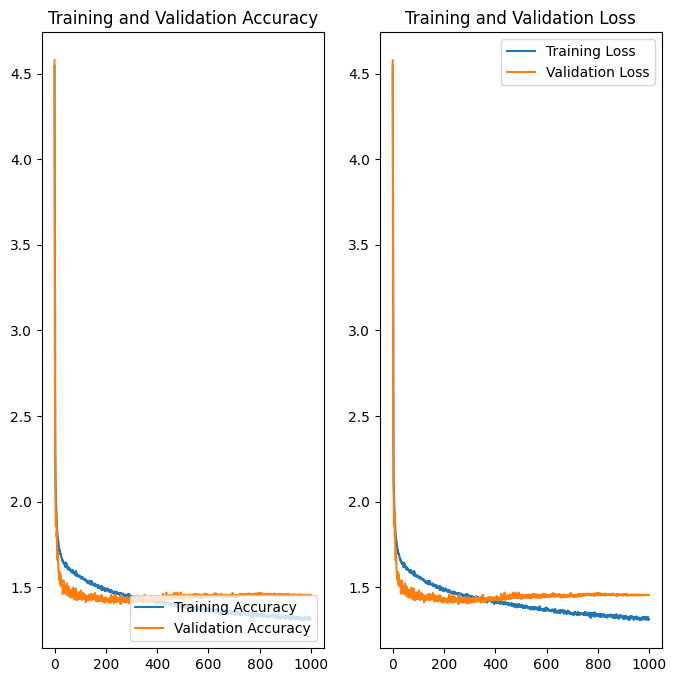

In [27]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Guardamos los datos Accuracy y Loss

In [28]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 50,100/historytrayec100.csv', index=False)

# Guardamos el modelo

In [29]:
path_to_save = '../../../Modelos/Modelos 50,100'

In [30]:
model.save(path_to_save + '/trayectorias100.h5')

# Importamos el modelo

In [33]:
new_model = keras.models.load_model('../../../Modelos/Modelos 50,100/trayectorias100.h5')

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [34]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[4, 5, 8, 4, 3, 5, 2]
(10, 2, 100)


In [35]:
varfnone = varf[None, :]

## Predecimos con los datos nuevos

In [36]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 63ms/step
[[7. 1. 8. 5. 3. 5. 2.]]


## Graficamos con los coeficientes reales

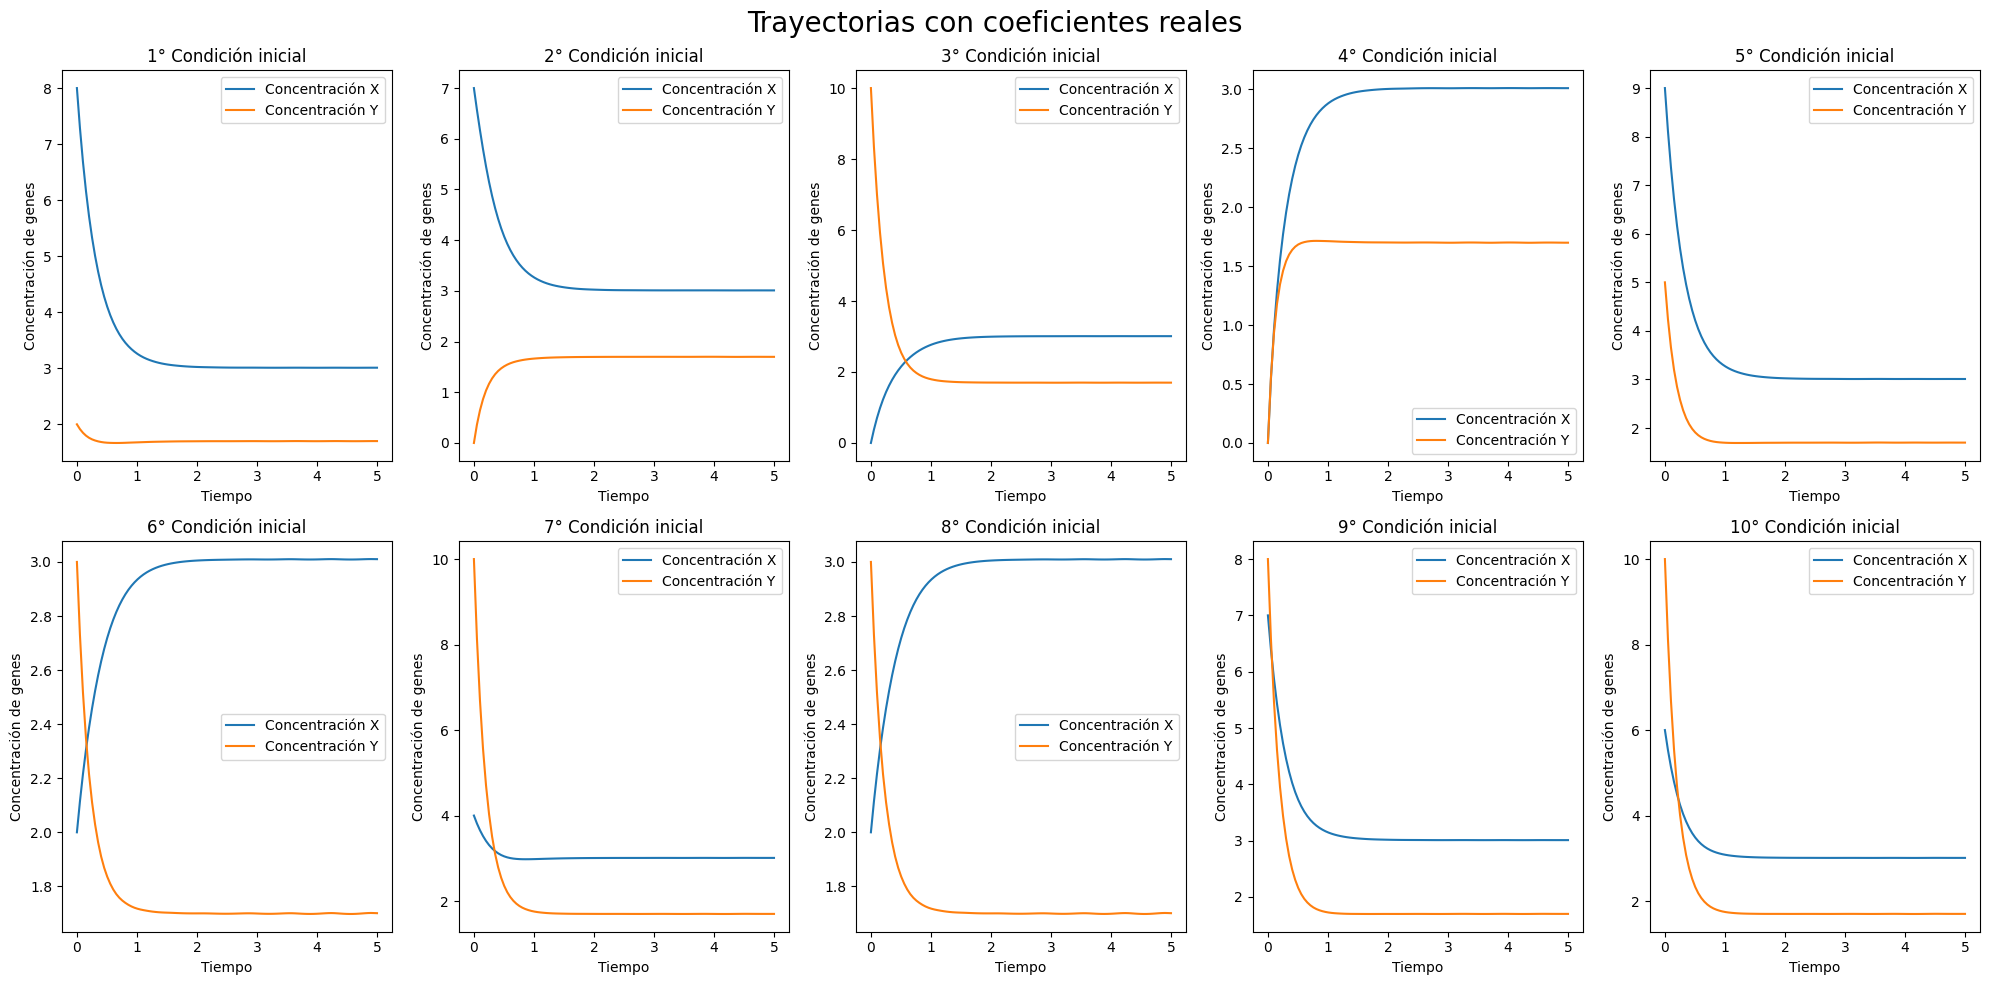

In [37]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [38]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

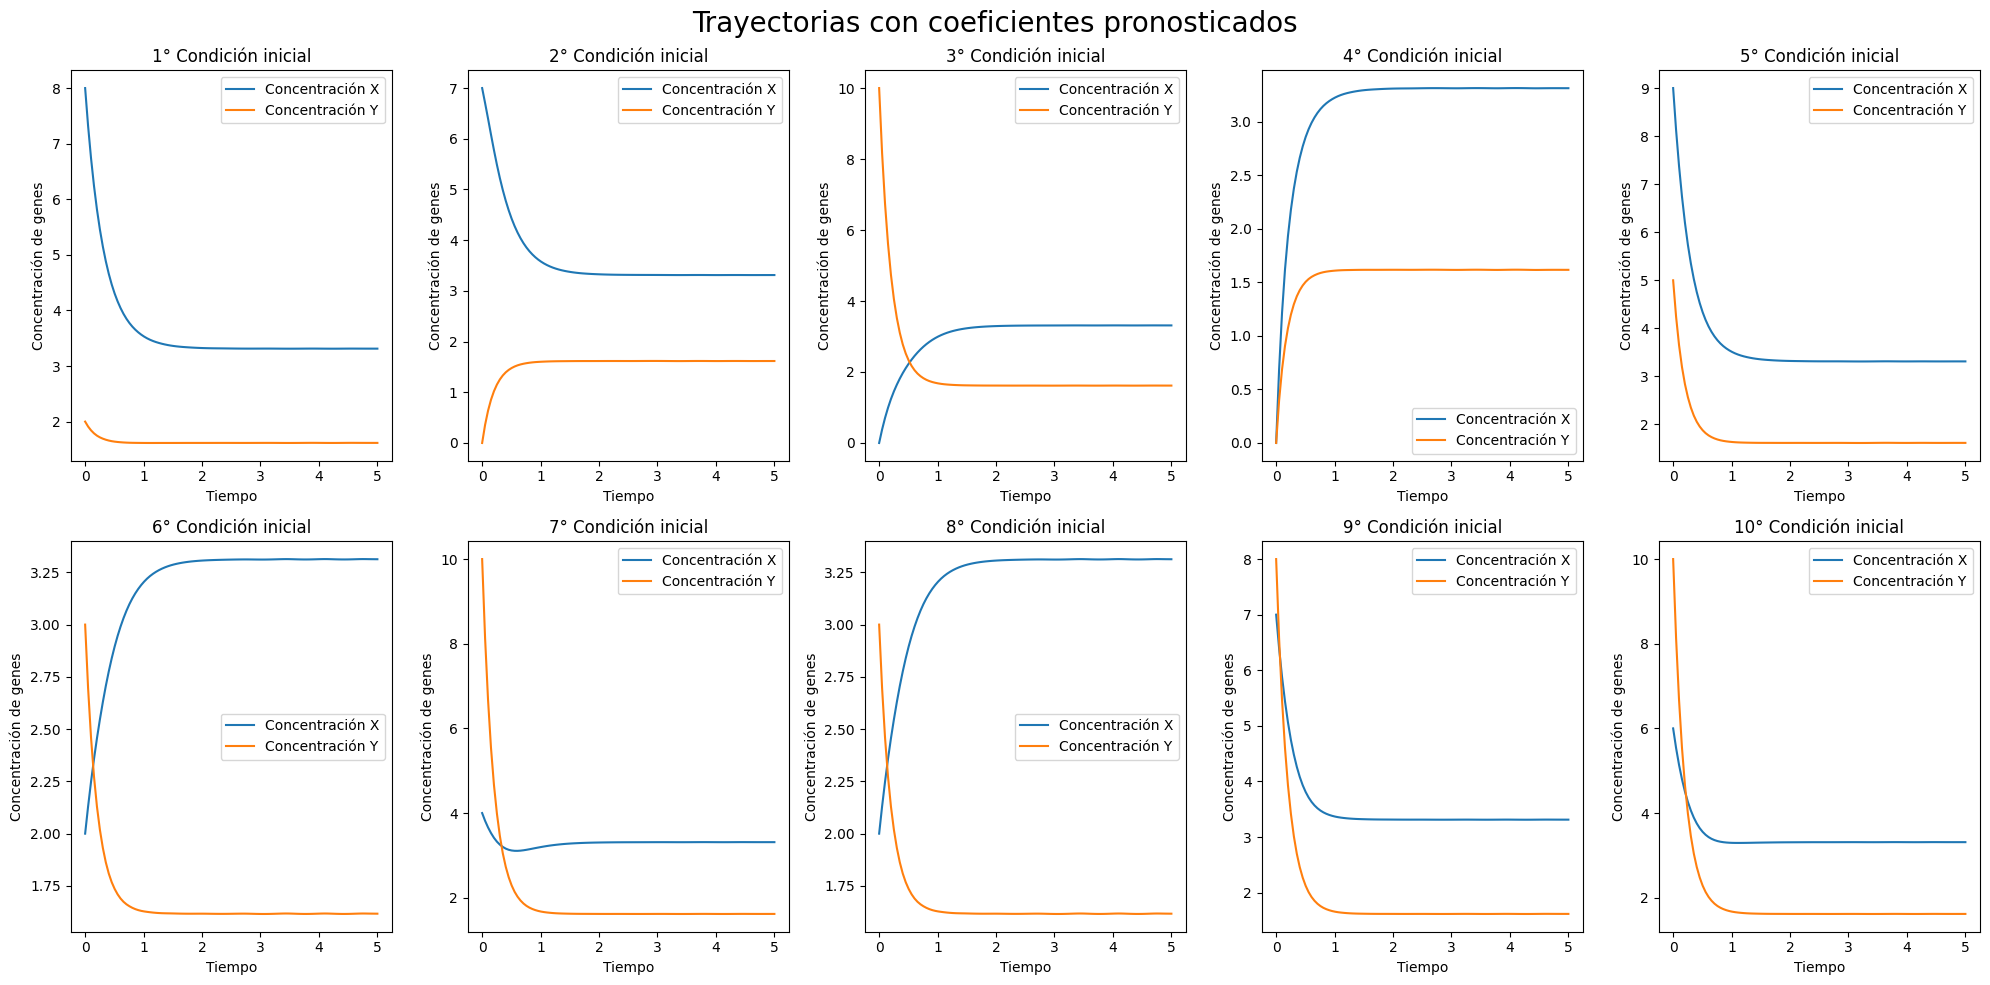

In [39]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

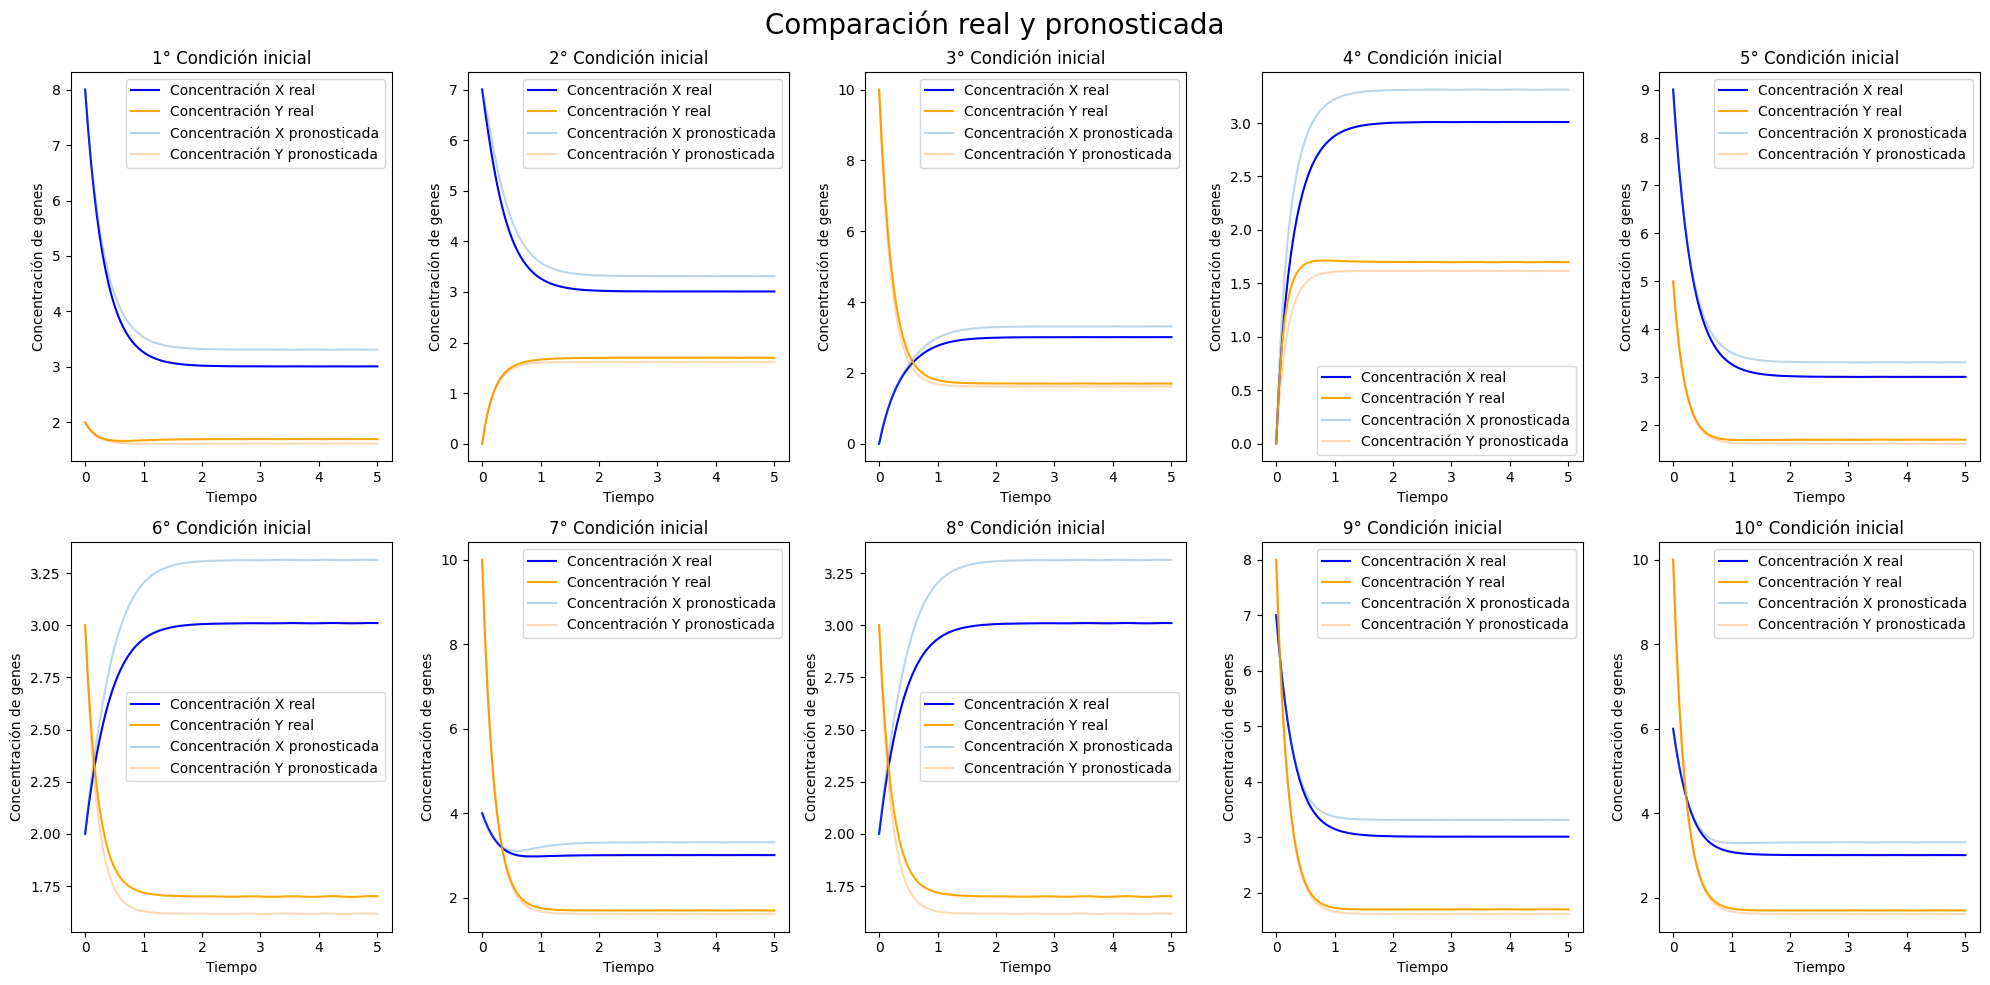

In [40]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

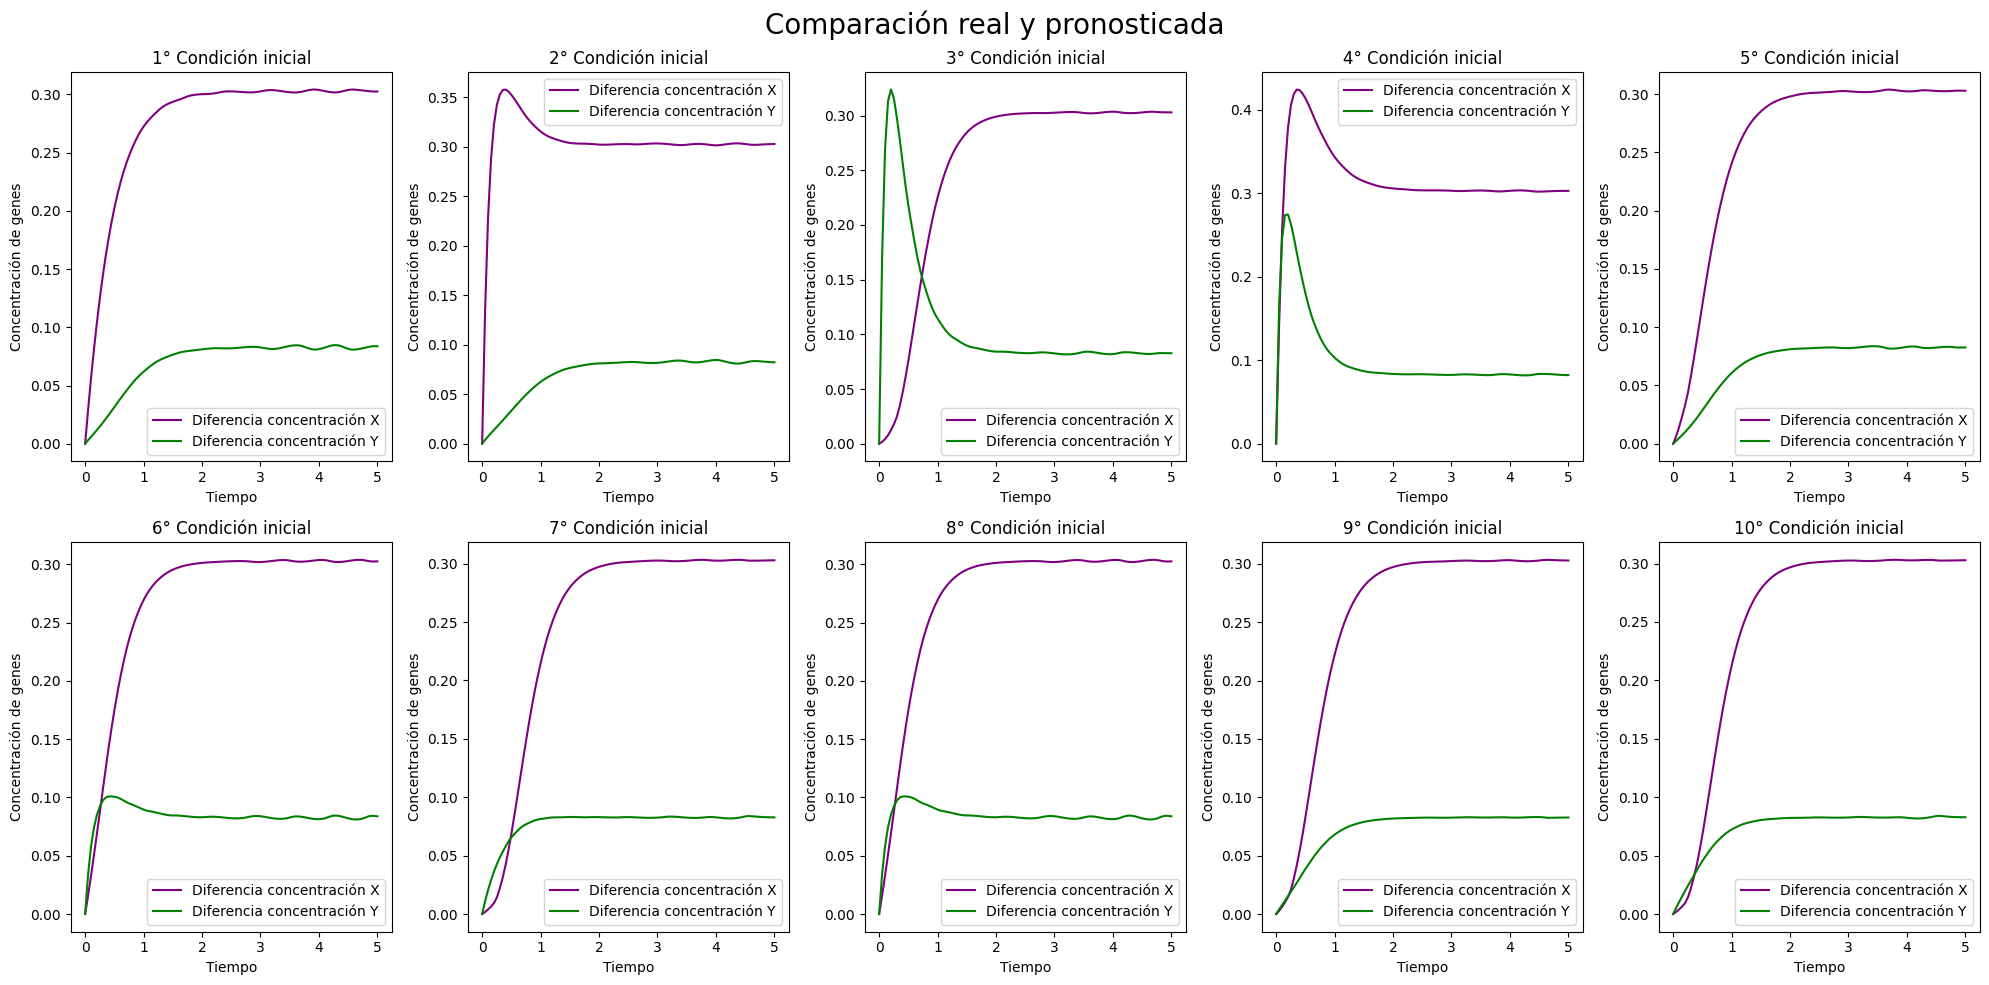

In [41]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.abs(np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :])
    diff_Y = np.abs(np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :])
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [42]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.13521213094050705
0.040640579586758034
